# Import Packages

In [1]:
import sys
import os
import shutil
import librosa
import glob
import tqdm
import json
import ast
import random

from librosa import display as ld

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import models, layers
from tensorflow.keras import backend as K

!pip install git+https://github.com/AI-Guru/ngdlm.git
tf.compat.v1.disable_eager_execution()

from sklearn.preprocessing import StandardScaler
from sklearn.externals.joblib import load, dump
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython import display as ipd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from configparser import ConfigParser

  Cloning https://github.com/AI-Guru/ngdlm.git to /tmp/pip-req-build-9om7ay7v
  Running command git clone -q https://github.com/AI-Guru/ngdlm.git /tmp/pip-req-build-9om7ay7v
  Created wheel for ngdlm: filename=ngdlm-0.0.3-py2.py3-none-any.whl size=32027 sha256=2c87a87b36bf90da279551b874a51b9431e4cae7f04a9c1de9c2c6d926c0bc0a
  Stored in directory: /tmp/pip-ephem-wheel-cache-u17w0e7z/wheels/93/06/27/e156acb49f475c364c3c9fa4ad4ab7bfa38808bff5bf9c4647
Successfully built ngdlm


/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Mount Google Drive
#### 1. First mount

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/sound-of-failure

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/sound-of-failure


# Import Own Modules

In [3]:
sys.path += ['src/01_data_processing', 'src/02_modelling', 'src/00_utils']

import spectrogram as spec
import train_test_split as splt
import train_model_autoencoder as train
import naming

# Global constants

### First run the scripts for building the config files.

Some of the parameters can be passed through the command line.
At present the command line parameters are the following :

1. conf_base.py : Script for building the base config file (saves in sound-of-failure/conf/conf_base.ini)
        -raw : Pass the location of the raw data dir


2. conf_convAE.py : Script for building the config file holding the parameters for Mel Spectrogram and Convolutional Autoencoder (saves in sound-of-failure/conf/make_conf_convAE.ini). Convolutional Autoencoders can be either Autoencoders or Variational Autoencoders.
        -ae : AE or VAE
        -mel : No. of mels
        -fft : No. of FFT bands
        -hop : Hop length for the sliding window while calculating FFT
        -dim : Time dimension of one spectrogram block after chunking the whole spectrogram
        -s : Step for the sliding window for creating chunks from one spectrogram


To check the description of the command line parameters one could activate the '-h' flag. For example :

In [ ]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_convAE.py -h

usage: make_conf_convAE.py [-h] [-ae] [-mel] [-fft] [-hop] [-dim] [-s]

Params for Spectrogram and Autoencoder (AE or VAE)

optional arguments:
  -h, --help            show this help message and exit
  -ae , --ae            Type of Autoencoder (AE or VAE)
  -mel , --n_mels       No. of mel bands
  -fft , --n_fft        No. of FFT bands
  -hop , --hop_length   Hop length for FFT calc
  -dim , --dim          Time dimension of Spectrogram block
  -s , --step           Sliding window step for Spectrogram chunking


#### Note the change here : While running VAE we have to specify -ae to VAE in the command line. This ensures that the right config file is created (conf/conf_VAE.ini).

In [7]:
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_base.py -raw '/gdrive/MyDrive/mimii_baseline/dataset' -prj '/gdrive/MyDrive'
%run /gdrive/MyDrive/sound-of-failure/src/00_utils/make_conf_convAE.py -prj '/gdrive/MyDrive' -ae VAE -mel 16 -fft 1024 -hop 512 -dim 32 -s 8

### Then read from the config files

There are two config files : 

1. sound-of-failure/conf/**conf_base**.ini
2. sound-of-failure/conf/**conf_VAE**.ini

##### Note the change here : In normal Autoencoders the created config file is called conf_convAE.ini. Now is is called conf_VAE.ini.

In [4]:
base_conf = train.read_config('/gdrive/MyDrive/sound-of-failure/conf/conf_base.ini')
param_conf = train.read_config('/gdrive/MyDrive/sound-of-failure/conf/conf_VAE.ini')

#### Read the parameters directly from the config files

Question : Should the reading of config files be done within notebooks or the source script should directly read from them?

In [5]:
# Directories
RAW_DATA_DIR = base_conf['directories']['raw_data_dir']
BASE_DIR = base_conf['directories']['base_dir']


# Mel spectrograms
N_MELS = param_conf.getint('melspec', 'n_mels')
N_FFT = param_conf.getint('melspec', 'n_fft')
HOP_LENGTH = param_conf.getint('melspec', 'hop_length')
POWER = param_conf.getfloat('melspec', 'power')
WINDOW = param_conf.get('melspec', 'window')


# Subsampling
DIM = param_conf.getint('melspec', 'dim')
STEP = param_conf.getint('melspec', 'step')


# Scaler and cost function
SCALER_TYPE = param_conf.get('model', 'scaler')
LOSS = param_conf.get('model', 'loss')


# Optimizer
OPTIMIZER = param_conf.get('model', 'optimizer')
EPOCHS = param_conf.getint('model', 'epochs')
BATCH_SIZE = param_conf.getint('model', 'batch_size')
VALIDATION_SPLIT = param_conf.getfloat('model', 'val_split')
SHUFFLE = param_conf.getboolean('model', 'shuffle')


# Autoencoder
INPUT_SHAPE = (param_conf.getint('melspec', 'dim'),
               param_conf.getint('melspec', 'n_mels'),
               1)

LATENT_DIM = param_conf.getint('autoencoder', 'latentdim')
NUM_NODES = json.loads(param_conf.get('autoencoder', 'num_nodes'))
NUM_KERNEL = json.loads(param_conf.get('autoencoder', 'num_kernel'))
NUM_STRIDES = param_conf.get('autoencoder', 'num_strides')
NUM_STRIDES = list(ast.literal_eval(NUM_STRIDES))


# Data
DB = param_conf.get('data', 'noise')
MACHINE_TYPE = param_conf.get('data', 'machine')
MACHINE_ID = param_conf.get('data', 'machine_id')

# Demo of new naming convention

In [11]:
MODEL_NAME = 'VAE'

print(f'Default name string: {naming.get_default_name_string(MODEL_NAME, DB, MACHINE_TYPE, MACHINE_ID)}')
print(f'New name string: {naming.get_new_name_string(MODEL_NAME, DB, MACHINE_TYPE, MACHINE_ID)}\n')

name_string = naming.get_default_name_string(MODEL_NAME, DB, MACHINE_TYPE, MACHINE_ID)

print(f'Scaler path: {naming.get_scaler_path(name_string)}')
print(f'Config path: {naming.get_conf_path(name_string)}')
print(f'Model path: {naming.get_model_path(name_string)}')

Default name string: VAE_6dB_valve_id_00
New name string: VAE_6dB_valve_id_00

Scaler path: models/VAE_6dB_valve_id_00.gz
Config path: conf/VAE_6dB_valve_id_00.ini
Model path: models/VAE_6dB_valve_id_00.hdf5


# Execute preprocessing steps
#### 1. Generate unscaled mel spectrograms (~ 5 minutes)

In [11]:
spec.make_mel_dirs(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)

spec.make_mels(RAW_DATA_DIR, BASE_DIR, 
               DB, MACHINE_TYPE, MACHINE_ID, 
               N_MELS, N_FFT, HOP_LENGTH, POWER, WINDOW, overwrite=False)

Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal
Directory already exists: /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal


  0%|          | 0/991 [00:00<?, ?it/s]

Generate normal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/normal.


  0%|          | 0/119 [00:00<?, ?it/s]

Created 0 new spectrograms, kept 991 existing spectrograms.
Generate abnormal spectrograms and save to /gdrive/MyDrive/sound-of-failure/data/mel_spectrograms/6dB/valve/id_00/abnormal.


100%|██████████| 119/119 [00:01<00:00, 77.35it/s]

Created 0 new spectrograms, kept 119 existing spectrograms.


#### 2. Separate train and test files

In [12]:
train_files, train_labels, test_files, test_labels = splt.make_train_test_split(BASE_DIR, 
                                                                                DB, MACHINE_TYPE, MACHINE_ID, 
                                                                                random_seed=1)

# Manual data exploration

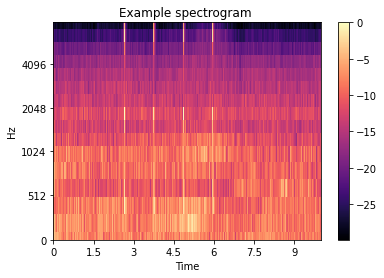

In [22]:
spect = np.load(spec.get_abnormal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0])

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

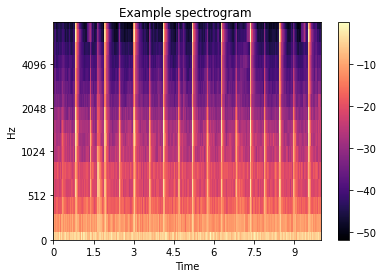

In [23]:
spect = np.load(spec.get_normal_mel_files(BASE_DIR, DB, MACHINE_TYPE, MACHINE_ID)[0])

fig, ax = plt.subplots()
plt.title("Example spectrogram ")
img = ld.specshow(spect, 
                    x_axis='time', 
                    y_axis='mel', 
                    sr=16000, 
                    fmax=8000, 
                    ax=ax)

fig.colorbar(img, ax=ax)
plt.show()
plt.close()

#### 3. Scaling

In [18]:
scaler_path = naming.get_scaler_path(name_string)
scaler = spec.fit_and_save_scaler(SCALER_TYPE, train_files, scaler_path, overwrite=True)

  5%|▍         | 41/872 [00:00<00:02, 404.43it/s]

Overwriting existing scaler models/VAE_6dB_valve_id_00.gz.


100%|██████████| 872/872 [00:02<00:00, 378.58it/s]

Saving scaler to models/VAE_6dB_valve_id_00.gz.


In [24]:
scaler = spec.fit_and_save_scaler(SCALER_TYPE, train_files, name_string, overwrite=False)

Loading existing scaler models/VAE_6dB_valve_id_00.gz.


#### 4. Subsample data for training

In [30]:
train_data = splt.generate_train_data(train_files, scaler, DIM, STEP)
train_data = train_data[:,:,:,0]

100%|██████████| 872/872 [00:12<00:00, 69.45it/s]


In [31]:
model = models.Sequential()
model.add(layers.LSTM(128, input_shape=(train_data.shape[1], train_data.shape[2]), return_sequences=True))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.RepeatVector(train_data.shape[1]))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.LSTM(128, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(train_data.shape[2])))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32, 128)           74240     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 32, 128)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_4 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
time_distributed (TimeDistri (None, 32, 16)            2

Train on 29037 samples, validate on 3227 samples
Epoch 1/30
29037/29037 [==============================] - ETA: 0s - loss: 0.2162

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


29037/29037 [==============================] - 152s 5ms/sample - loss: 0.2162 - val_loss: 0.1153
Epoch 2/30
29037/29037 [==============================] - 149s 5ms/sample - loss: 0.1004 - val_loss: 0.0722
Epoch 3/30
29037/29037 [==============================] - 149s 5ms/sample - loss: 0.0664 - val_loss: 0.0544
Epoch 4/30
29037/29037 [==============================] - 150s 5ms/sample - loss: 0.0504 - val_loss: 0.0422
Epoch 5/30
29037/29037 [==============================] - 149s 5ms/sample - loss: 0.0434 - val_loss: 0.0497
Epoch 6/30
29037/29037 [==============================] - 149s 5ms/sample - loss: 0.0384 - val_loss: 0.0376
Epoch 7/30
29037/29037 [==============================] - 150s 5ms/sample - loss: 0.0343 - val_loss: 0.0379
Epoch 8/30
29037/29037 [==============================] - 149s 5ms/sample - loss: 0.0329 - val_loss: 0.0330
Epoch 9/30
29037/29037 [==============================] - 149s 5ms/sample - loss: 0.0305 - val_loss: 0.0315
Epoch 10/30
29037/29037 [==============

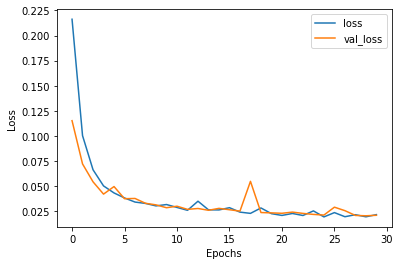

In [32]:
model.compile(loss= 'mse' , optimizer= 'adam')

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

history = model.fit(train_data,
                    train_data,
                    epochs=30,
                    batch_size=BATCH_SIZE,
                    validation_split=VALIDATION_SPLIT,
                    shuffle=True,
                    verbose=1,
                    callbacks=[callback])

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
plt.close()

In [34]:
y_score = np.zeros(len(test_files))
y_true = test_labels

for idx, test_file in tqdm.tqdm(enumerate(test_files), total=len(test_files)):
  mel = np.load(test_file)

  scaled_mel = spec.apply_scaler_to_mel(scaler, mel)

  batch = splt.subsample_from_mel(scaled_mel, DIM, STEP)
  batch = batch[:,:,:,0]

  batch_prediction = model.predict(batch)

  squared_error = np.square(batch - batch_prediction)
  channelwise_error = np.mean(squared_error, axis=-1)
  reconstruction_error = np.mean(channelwise_error)

  y_score[idx] = reconstruction_error


auc_score = metrics.roc_auc_score(y_true, y_score)
print("Roc AUC score={}".format(auc_score))

  0%|          | 0/238 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
100%|██████████| 238/238 [01:20<00:00,  2.97it/s]

Roc AUC score=0.9741543676294047


In [33]:
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras import backend as K
import numpy as np

class lstmAutoencoder:

  def __init__(self,
               input_shape,
               num_units):
    self.input_shape = input_shape # [32, 16]
    self.num_units = num_units # [128, 128, 128, 64, ...]

    self.encoder = None
    self.decoder = None
    self.model = None

    self.num_lstm_layers = len(num_units)

    self.build_network()

  def build_network(self):
    self.build_encoder()
    self.build_decoder()
    self.build_autoencoder()

  def build_encoder(self):
    encoder_input = self.build_encoder_input()
    lstm_layers = self.build_lstm_layers(encoder_input)
    


  

